In [15]:
import numpy as np
import terra

from meerkat.contrib.eeg import build_stanford_eeg_dp

from domino.emb.eeg import generate_words_dp, embed_words, embed_eeg
from domino.evaluate import run_sdms, score_sdm_explanations, score_sdms, run_sdm
from domino.sdm import MixtureModelSDM, SpotlightSDM
from domino.slices import collect_settings
from domino.train import score_settings, synthetic_score_settings, train_settings
from domino.utils import split_dp, balance_dp

import meerkat as mk
import seaborn as sns
import matplotlib.pyplot as plt


In [34]:
setting_dp = collect_settings.out(load=True)
setting_dp

,alpha (NumpyArrayColumn),build_setting_kwargs (ListColumn),dataset (PandasSeriesColumn),slice_category (PandasSeriesColumn),slice_names (ListColumn),target_name (PandasSeriesColumn),index (PandasSeriesColumn),setting_id (PandasSeriesColumn)
0,0.000,"{'correlate': 'age', 'corr': 0.0, 'correlate_threshold': 1, 'n': 8000}",eeg,correlation,"['sz=0_age=1', 'sz=1_age=0']",sz,0,f88891e6-de6c-4e8c-81f9-060cdc77ecdf
1,0.225,"{'correlate': 'age', 'corr': 0.225, 'correlate_threshold': 1, 'n': 8000}",eeg,correlation,"['sz=0_age=1', 'sz=1_age=0']",sz,1,b8c926bc-7f34-4915-a1a8-617f25717b69
2,0.450,"{'correlate': 'age', 'corr': 0.45, 'correlate_threshold': 1, 'n': 8000}",eeg,correlation,"['sz=0_age=1', 'sz=1_age=0']",sz,2,878310b7-bc1c-4b8f-a718-1f1ed1061838
3,0.675,"{'correlate': 'age', 'corr': 0.675, 'correlate_threshold': 1, 'n': 8000}",eeg,correlation,"['sz=0_age=1', 'sz=1_age=0']",sz,3,63a56621-5bce-44d8-abc2-bdeaf03bef06
4,0.900,"{'correlate': 'age', 'corr': 0.9, 'correlate_threshold': 1, 'n': 8000}",eeg,correlation,"['sz=0_age=1', 'sz=1_age=0']",sz,4,332fed15-6acb-4156-9ac7-16ef02203ff2


In [35]:
run_sdms_dp = run_sdms.out(load=True)
run_sdms_dp.head()

,score_model_run_id (NumpyArrayColumn),setting_id (PandasSeriesColumn),build_setting_run_id (NumpyArrayColumn),score_settings_run_id (NumpyArrayColumn),synthetic_preds (NumpyArrayColumn),index (PandasSeriesColumn),alpha (NumpyArrayColumn),build_setting_kwargs (ListColumn),dataset (PandasSeriesColumn),slice_category (PandasSeriesColumn),slice_names (ListColumn),target_name (PandasSeriesColumn),run_sdm_run_id (PandasSeriesColumn),time_this_iter_s (PandasSeriesColumn),done (PandasSeriesColumn),timesteps_total (PandasSeriesColumn),episodes_total (PandasSeriesColumn),training_iteration (PandasSeriesColumn),experiment_id (PandasSeriesColumn),date (PandasSeriesColumn),timestamp (PandasSeriesColumn),time_total_s (PandasSeriesColumn),pid (PandasSeriesColumn),hostname (PandasSeriesColumn),node_ip (PandasSeriesColumn),time_since_restore (PandasSeriesColumn),timesteps_since_restore (PandasSeriesColumn),iterations_since_restore (PandasSeriesColumn),trial_id (PandasSeriesColumn),sdm_config/weight_y_log_likelihood (PandasSeriesColumn),sdm_config/n_slices (PandasSeriesColumn),sdm_config/n_clusters (PandasSeriesColumn),sdm_config/emb (PandasSeriesColumn),config/sdm (PandasSeriesColumn),config/slice (PandasSeriesColumn),logdir (PandasSeriesColumn),sdm_class (PandasSeriesColumn)
0,907,f88891e6-de6c-4e8c-81f9-060cdc77ecdf,907,906,True,0,0.000,"{'correlate': 'age', 'corr': 0.0, 'correlate_threshold': 1, 'n': 8000}",eeg,correlation,"['sz=0_age=1', 'sz=1_age=0']",sz,933,1.704915,False,NaN,NaN,1,d7a530220ba74691937a4ef6357d9d6b,2021-09-23_23-50-26,1632466226,1.704915,8995,gemini1,171.65.28.88,1.704915,0,1,aaf96_00000,10,10,10,emb,"{'sdm_class': '', 'sdm_config': {'emb': ['eeg', 'emb'], 'n_clusters': 10, 'n_slices': 10, 'weight_y_log_likelihood': 10}}","{'alpha': 0.0, 'build_setting_kwargs': {'corr': 0.0, 'correlate': 'age', 'correlate_threshold': 1, 'n': 8000}, 'build_setting_run_id': 907, 'dataset': 'eeg', 'index': '0', 'score_model_run_id': 907, 'score_settings_run_id': 906, 'setting_id': 'f88891e6-de6c-4e8c-81f9-060cdc77ecdf', 'slice_category': 'correlation', 'slice_names': ['sz=0_age=1', 'sz=1_age=0'], 'synthetic_preds': 'True', 'target_name': 'sz'}","/media/4tb_hdd/terra/slice/tasks/evaluate/run_sdms/_runs/931/_evaluate_2021-09-23_23-50-13/_evaluate_aaf96_00000_0_sdm={'sdm_class': , 'sdm_config': {'weight_y_log_likelihood': 10, _2021-09-23_23-50-13",domino.sdm.gmm.MixtureModelSDM
1,907,f88891e6-de6c-4e8c-81f9-060cdc77ecdf,907,906,True,1,0.000,"{'correlate': 'age', 'corr': 0.0, 'correlate_threshold': 1, 'n': 8000}",eeg,correlation,"['sz=0_age=1', 'sz=1_age=0']",sz,932,1.242463,False,NaN,NaN,1,8dfdc43e87f249dba302c16dc20e8e27,2021-09-23_23-50-25,1632466225,1.242463,9035,gemini1,171.65.28.88,1.242463,0,1,aaf96_00001,10,10,10,emb,"{'sdm_class': '', 'sdm_config': {'emb': ['multimodal', 'emb'], 'n_clusters': 10, 'n_slices': 10, 'weight_y_log_likelihood': 10}}","{'alpha': 0.0, 'build_setting_kwargs': {'corr': 0.0, 'correlate': 'age', 'correlate_threshold': 1, 'n': 8000}, 'build_setting_run_id': 907, 'dataset': 'eeg', 'index': '0', 'score_model_run_id': 907, 'score_settings_run_id': 906, 'setting_id': 'f88891e6-de6c-4e8c-81f9-060cdc77ecdf', 'slice_category': 'correlation', 'slice_names': ['sz=0_age=1', 'sz=1_age=0'], 'synthetic_preds': 'True', 'target_name': 'sz'}","/media/4tb_hdd/terra/slice/tasks/evaluate/run_sdms/_runs/931/_evaluate_2021-09-23_23-50-13/_evaluate_aaf96_00001_1_sdm={'sdm_class': , 'sdm_config': {'weight_y_log_likelihood': 10, _2021-09-23_23-50-13",domino.sdm.gmm.MixtureModelSDM
2,908,b8c926bc-7f34-4915-a1a8-617f25717b69,908,906,True,2,0.225,"{'correlate': 'age', 'corr': 0.225, 'correlate_threshold': 1, 'n': 8000}",eeg,correlation,"['sz=0_age=1', 'sz=1_age=0']",sz,935,1.423305,False,NaN,NaN,1,023a45f1bac9421db174c94daec3606d,2021-09-23_23-50-26,1632466226,1.423305,9040,gemini1,171.65.28.88,1.423305,0,1,aaf96_00002,10,10,10,emb,"{'sdm_class': '', 'sdm_config': {'emb': ['eeg', 'emb'], 'n_clusters': 10, 'n_slices': 10, 'weight_y_log_likeli

In [36]:
score_dp = mk.DataPanel.from_pandas(score_sdms.out(load=True))
score_dp

,pred_slice_idx (PandasSeriesColumn),slice_idx (PandasSeriesColumn),auroc (PandasSeriesColumn),precision_at_10 (PandasSeriesColumn),precision_at_25 (PandasSeriesColumn),precision_at_100 (PandasSeriesColumn),recall_at_50 (PandasSeriesColumn),recall_at_100 (PandasSeriesColumn),recall_at_200 (PandasSeriesColumn),recall (PandasSeriesColumn),precision (PandasSeriesColumn),target_name (PandasSeriesColumn),run_sdm_run_id (PandasSeriesColumn),slice_name (PandasSeriesColumn),index (PandasSeriesColumn)
0,0.0,0.0,0.067254,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,sz,933.0,sz=0_age=1,0
1,1.0,0.0,0.154494,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,sz,933.0,sz=0_age=1,1
2,2.0,0.0,0.861695,0.3,0.32,0.35,0.071429,0.178571,0.459184,0.142857,0.345679,sz,933.0,sz=0_age=1,2
3,3.0,0.0,0.848225,0.7,0.64,0.56,0.239796,0.285714,0.571429,0.413265,0.570423,sz,933.0,sz=0_age=1,3
4,4.0,0.0,0.852939,0.1,0.16,0.30,0.107143,0.153061,0.336735,0.127551,0.268817,sz,933.0,sz=0_age=1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,5.0,1.0,0.627139,0.0,0.00,0.01,0.000000,0.031250,0.281250,0.062500,0.017391,sz,936.0,sz=1_age=0,195
196,6.0,1.0,0.498292,0.0,0.00,0.04,0.093750,0.125000,0.250000,0.218750,0.040462,sz,936.0,sz=1_age=0,196
197,7.0,1.0,0.456139,0.0,0.00,0.00,0.000000,0.000000,0.031250,0.000000,0.000000,sz,936.0,sz=1_age=0,197
198,8.0,1.0,0.651806,0.3,0.20,0.11,0.250000,0.343750,0.437500,0.000000,0.000000,sz,936.0,sz=1_age=0,198


In [37]:
results_dp = mk.merge(
    score_dp,
    run_sdms_dp["config/sdm", "alpha","run_sdm_run_id"], # include any other columns here you'd like to analyze
    on="run_sdm_run_id"
)
emb_col = results_dp["config/sdm"].map(lambda x: x["sdm_config"]["emb"][0])
results_dp["emb_type"] = emb_col

results_df = results_dp.to_pandas()
results_df

,run_sdm_run_id,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision,target_name,slice_name,index,config/sdm,alpha,emb_type
0,933,0,0,0.067254,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,sz,sz=0_age=1,0,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,eeg
1,933,1,0,0.154494,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,sz,sz=0_age=1,1,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,eeg
2,933,2,0,0.861695,0.3,0.32,0.35,0.071429,0.178571,0.459184,0.142857,0.345679,sz,sz=0_age=1,2,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,eeg
3,933,3,0,0.848225,0.7,0.64,0.56,0.239796,0.285714,0.571429,0.413265,0.570423,sz,sz=0_age=1,3,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,eeg
4,933,4,0,0.852939,0.1,0.16,0.30,0.107143,0.153061,0.336735,0.127551,0.268817,sz,sz=0_age=1,4,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,eeg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,936,5,1,0.627139,0.0,0.00,0.01,0.000000,0.031250,0.281250,0.062500,0.017391,sz,sz=1_age=0,195,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.9,multimodal
196,936,6,1,0.498292,0.0,0.00,0.04,0.093750,0.125000,0.250000,0.218750,0.040462,sz,sz=1_age=0,196,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.9,multimodal
197,936,7,1,0.456139,0.0,0.00,0.00,0.000000,0.000000,0.031250,0.000000,0.000000,sz,sz=1_age=0,197,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.9,multimodal
198,936,8,1,0.651806,0.3,0.20,0.11,0.250000,0.343750,0.437500,0.000000,0.000000,sz,sz=1_age=0,198,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.9,multimodal


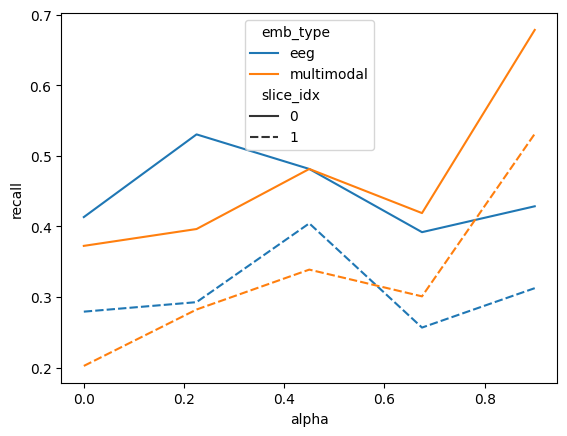

In [50]:
metric = "auroc"
grouped_df = results_df.iloc[results_df.reset_index().groupby(["slice_name", "slice_idx","emb_type","alpha"])[metric].idxmax().astype(int)]


mask = grouped_df["slice_idx"]==1
ax = sns.lineplot(data=grouped_df,x="alpha",y=metric, hue="emb_type",style="slice_idx")
plt.show()